# Out results

In [263]:
#!pip install arviz
#!pip install pymc3
#!pip install fitter

In [225]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import arviz as az
%matplotlib inline

from ab_testing.constants import client_name, target_col
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from ab_testing.predictions.produce_predictions import ProducePredictions

Using Matus's code output and augmenting the ab_testing library to produc the sampled posterior distributions we are able to show the distribution of possible posteriors aka the distribution of the possible ab-test outcomes. The HDI's constructed show the 90% density of observed sample outcomes, if the two are non-overlaping the test can be seen as "conclusive" from a frequentist pov, aka the difference in ARPUs HDI does not include 0.

In [328]:
initial_data = pd.read_parquet("./bingo_aloha_data.p")

fit_dist = FitDistribution(fname=f"{client_name}_distribution_fit.p")
best_distribution = fit_dist.fit(initial_data.loc[initial_data[target_col] > 0], target_col)

result = ProducePredictions()
results_conversion = result.produce_results_conversion(initial_data)
results_revenue = result.produce_results_revenue(best_distribution, initial_data)

results_posterior_sample = result._produce_results_lognorm_dist_carry_value(initial_data)
# Above added on inside ab_testing library <- cross checking with R implementation given for some reason more accurate
# results then the results generated by Matus, not sure whats up w/ that.

Below set the creadibility mass (a bayesian term analogous to a confidence interval but with signifificantly differenet logic behind it (see refernece at end)). And construct the hdi threasholds using the arviz library.

In [329]:
credMass = 0.9
post_sample_A      = results_posterior_sample[1]
post_sample_B      = results_posterior_sample[0]
post_sample_uplift = (post_sample_B - post_sample_A) / post_sample_A
hdi_A              = az.hdi(post_sample_A, hdi_prob=credMass)
hdi_B              = az.hdi(post_sample_B, hdi_prob=credMass)
hdi_diff           = az.hdi(diff_post_sample, hdi_prob=credMass)

Create table 1:

In [321]:
output_df = pd.DataFrame(columns=["Metric", "Conversion", "Revenue"])
output_df["Metric"] = ["P( P > C)", "E( loss | P > C)", "E( loss | C > P)"]
output_df["Conversion"] = [
    "%.4f%%" % (results_conversion[0]["prob_being_best"] * 100),
    "%.4f%%" % (results_conversion[0]["expected_loss"] * 100),
    "%.4f%%" % (results_conversion[1]["expected_loss"] * 100),
]
output_df["Revenue"] = [
    "%.4f%%" % (results_revenue[0]["prob_being_best"] * 100),
    "%.4f%%" % (results_revenue[0]["expected_loss"] * 100),
    "%.4f%%" % (results_revenue[1]["expected_loss"] * 100),
]

output_df

,Metric,Conversion,Revenue
0,P( P > C),12.51%,0.91%
1,E( loss | P > C),0.0915%,12.4055%
2,E( loss | C > P),0.0047%,0.0154%


Create table 2:

In [322]:
output_df2 = pd.DataFrame(columns=["Metric", "Control", "Personalised", "Personalised-Control"])
output_df2["Metric"] = ["sample size", "conversion", "ARPU", "ARPPU", "95% HDI"]
output_df2["Control"] = [
    "%d" % (results_revenue[1]['totals']),
    "%.2f%%" % (results_conversion[1]['positive_rate'] * 100),
    "%.4f€" % (results_revenue[1]['avg_values']),
    "%.4f€" % (results_revenue[1]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_A[0], hdi_A[1]),
]
output_df2["Personalised"] = [
    "%d" % (results_revenue[0]['totals']),
    "%.2f%%" % (results_conversion[0]['positive_rate'] * 100),
    "%.4f€" % (results_revenue[0]['avg_values']),
    "%.4f€" % (results_revenue[0]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_B[0], hdi_B[1]),
]
output_df2["Personalised-Control"] = [
    np.NAN,
    "%.2f%%" % ((results_conversion[0]['positive_rate'] - results_conversion[1]['positive_rate']) * 100),
    "%.4f€" % (results_revenue[0]['avg_values'] - results_revenue[1]['avg_values']),
    "%.4f€" % (results_revenue[0]['avg_positive_values'] - results_revenue[1]['avg_positive_values']),
    "[%.4f€, %.4f€]" % (hdi_diff[0], hdi_diff[1]),
]
output_df2

,Metric,Control,Personalised,Personalised-Control
0,sample size,240606,102902,NaN
1,conversion,4.24%,4.15%,-0.09%
2,ARPU,1.5025€,1.3391€,-0.1634€
3,ARPPU,35.4382€,32.2476€,-3.1906€
4,95% HDI,"[1.2014€, 1.3017€]","[1.0615€, 1.1978€]","[-0.1648€, -0.0350€]"


Create plot 1:

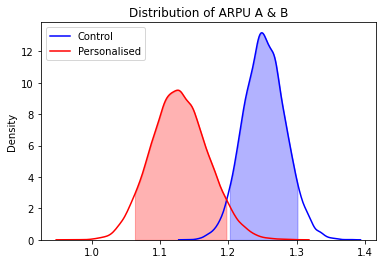

In [256]:
fig1 = sns.kdeplot(post_sample_A, color="blue")
fig1 = sns.kdeplot(post_sample_B, color="red")
l1 = fig1.lines[0]
l2 = fig1.lines[1]
x1 = l1.get_xydata()[:,0]
x2 = l2.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
y2 = l2.get_xydata()[:,1]
x1_new = x1[[all(tup) for tup in zip(list(x1 >= hdi_A[0]), list(x1 <= hdi_A[1]))]]
x2_new = x2[[all(tup) for tup in zip(list(x2 >= hdi_B[0]), list(x2 <= hdi_B[1]))]]
y1_new = y1[[all(tup) for tup in zip(list(x1 >= hdi_A[0]), list(x1 <= hdi_A[1]))]]
y2_new = y2[[all(tup) for tup in zip(list(x2 >= hdi_B[0]), list(x2 <= hdi_B[1]))]]
fig1.fill_between(x1_new, y1_new, color="blue", alpha=0.3)
fig1.fill_between(x2_new, y2_new, color="red", alpha=0.3)
fig1.set(title='Distribution of ARPU A & B')
fig1.legend(labels=['Control','Personalised'])
plt.pyplot.show()

Create plot 2:

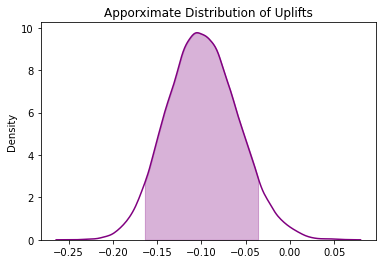

In [259]:
fig = sns.kdeplot(post_sample_uplift, color="purple")
l = fig.lines[0]
x = l.get_xydata()[:,0]
y = l.get_xydata()[:,1]
x_new = x[[all(tup) for tup in zip(list(x >= hdi_diff[0]), list(x <= hdi_diff[1]))]]
y_new = y[[all(tup) for tup in zip(list(x >= hdi_diff[0]), list(x <= hdi_diff[1]))]]
fig.fill_between(x_new, y_new, color="purple", alpha=0.3)
fig.set(title='Apporximate Distribution of Uplifts')
plt.pyplot.show()

In [70]:
from math import exp
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy.stats import norm, lognorm, expon, kstest

import arviz as az
import pymc3 as pm

from fitter import get_distributions, get_common_distributions

DISTRIBUTIONS = ["expon", "lognorm"]
client_name = "bingo_aloha"
target_col = "total_wins_spend"
df = pd.read_parquet("")
data = df[df[target_col] > 0]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=data, x=target_col, kind="hist", bins = 100, aspect = 1.5)

2022-09-15 15:01:01,342 - theano.link.c.cmodule - WARNING - install mkl with `conda install mkl-service`: No module named 'mkl'


FileNotFoundError: [Errno 2] No such file or directory: ''

AIC and BIC for (common) distributions

In [ ]:
df = pd.DataFrame(columns=["distribution", "AIC", "BIC"])
dists = []
aic = []
bic = []
for com_dist in get_common_distributions():
    dist = eval("scipy.stats." + com_dist)
    params = dist.fit(data[target_col].values)
    pdf_fitted = dist.pdf(data[target_col].values, *params)
    
    logLik = np.sum(dist.logpdf(data[target_col].values, *params))
    k = len(params[:])
    n = len(data[target_col].values)
    dists.append(com_dist)
    aic.append(2 * k - 2 * logLik)
    bic.append(k * np.log(n) - 2 * logLik)

df["distribution"] = dists
df["AIC"] = aic
df["BIC"] = bic
df.sort_values(by="AIC", inplace=True)
df.reset_index(inplace=True, drop=True)
df

Graphical fit for exponencial and lognormal distributions

In [ ]:
x = np.arange(len(data))
y = data[target_col].values
h = plt.hist(y, bins=range(48))

for dist_name in DISTRIBUTIONS:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * len(data)
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * len(data)
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0, np.quantile(data[target_col], 0.99))
plt.legend(loc='upper right')
plt.show()

Kolmogorov-SMirnov test for exponencial and lognormal distributions

In [ ]:
print("KS Test:")

print("Exponential distribution:")

loc, scale = expon.fit(data[target_col].values)

stat, p = kstest(data[target_col].values, 'expon', args=(loc, scale))

print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

print("Log normal distribution:")

sigma, loc, scale = lognorm.fit(data[target_col].values)

stat, p = kstest(data[target_col].values, 'lognorm', args=(sigma, loc, scale))

print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

Graphical comparison for the chosen distribution using pymc3

In [ ]:
df_P = data.loc[(data["test_group"].str.lower() == "p") | (data["test_group"].str.lower() == "assetario")]
df_C = data.loc[(data["test_group"].str.lower() == "c") | (data["test_group"].str.lower() == "control")]
print("Personal group:")
print(df_P[target_col].describe())
print("Control group:")
print(df_C[target_col].describe())

Lognormal distribution

In [ ]:
for data in [df_P, df_C]:
    shape, loc, scale = lognorm.fit(data[target_col].values, floc=0)

    with pm.Model() as model:

        y = pm.Lognormal("y", mu=np.log(scale), sigma=shape)
        trace = pm.sample(1000, random_seed=42)

        print(f"For {data.test_group.value_counts().index.values[0]} group")
        print("scale = %9.5f" % scale)
        print("shape = %9.5f" % shape)
        print(az.summary(trace))
        az.plot_trace(trace)
        az.plot_posterior(trace, kind='hist')

Transformation to normal distribution

In [ ]:
for data in [df_P, df_C]:
    data[f"log_{target_col}"] = np.log(data[target_col])

    mu, std = norm.fit(data[f"log_{target_col}"].values)

    with pm.Model() as model:

        y = pm.Normal("y", mu=mu, sigma=std)
        trace = pm.sample(1000, random_seed=42)

        print(f"For {data.test_group.value_counts().index.values[0]} group")
        print("Mean = %9.5f" % mu)
        print("Stdev = %9.5f" % std)
        print(az.summary(trace))
        az.plot_trace(trace)
        az.plot_posterior(trace, hdi_prob=.75)